In [1]:
from imports import *

In [2]:
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
import time

# Preprocessing
Load the dataset. IF is then run on samples of the dataset with different anomaly rates.

In [8]:
df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]

In [9]:
dfsf = df[df["logged_in"]== 1]
print(len(dfsf)- len(dfsf.loc[dfsf["target"]=='normal.']))
dfsf = dfsf[sf_columns + ["target"]] 
# print(dfsf.head(1))
# Split the dataset into 2 classes for consistent anomaly_rate when sampling
dfsf_normal = dfsf.loc[dfsf["target"]=='normal.']
dfsf_attack = dfsf.loc[dfsf["target"]!='normal.']
# print(f"A sample normal frame: \t {dfsf_normal.head(1)}")
# print("-----------------")
# print(f"A sample attack frame: \t {dfsf_attack.head(1)}")

3377


In [10]:
frac = 0.1

dfsf_frac = dfsf_normal.sample(frac = frac, random_state = 1).append(dfsf_attack.sample(frac = frac, random_state = 1))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")

dfsf_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsf_frac["target"]]
toDecode = toDecodeSF
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsf_frac[f] = leSF.fit_transform(dfsf_frac[f])

dfsf_normed = preprocessing.normalize(dfsf_frac.drop(["target", "binary_target"], axis=1))

anomaly rate is 0.5% out of 70307 records


# Parameter tuning

In [20]:
def cross_validation_lof(contamination, n_neighbors, silent = True):
    highest_score = 0
    highest_score_c = 0
    #print("array:", contamination)
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = LocalOutlierFactor(n_neighbors= n_neighbors, metric='euclidean', algorithm = 'auto', contamination=c, n_jobs=-1).fit_predict(x_train)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_train, y_pred, labels=[-1]))
        f = f1_score(y_train, y_pred, average = 'weighted')
        fm = f1_score(y_train, y_pred, average = 'macro')
        p = precision_score(y_train, y_pred, pos_label = -1)
        r = recall_score(y_train, y_pred, pos_label = -1)
        a = roc_auc_score(y_train, y_pred)
        if r > highest_score: highest_score = r; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        # fp through formula
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        if not silent:
            print(f"Finished trainning in {t} seconds")
            print(f"contamination: {c} \t tp: {tp}/support: {s}/predicted: {len(positives)} -> fp = {len(positives) - tp}")
            print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f},{fm}")
            print("--------------------")
    return (highest_score_c, y_pred, f, len(positives) - tp, tp, p, r, t)

In [21]:
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

In [22]:
rs = 1
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation_lof(np.arange(0.01, 0.5, 0.01), 100, silent=False)
print("Time for LOF fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
Y_axis_auc.append()
best_param.append(cmax)

Finished trainning in 0:00:01.437470 seconds
contamination: 0.01 	 tp: 0/support: 241/predicted: 520 -> fp = 520
AUC : 59.7% 	 precision: 0.0942 	 recall: 0.597 	 f1: 0.9897146236380179,0.5612227425396267
--------------------
Finished trainning in 0:00:01.443590 seconds
contamination: 0.02 	 tp: 0/support: 241/predicted: 1055 -> fp = 1055
AUC : 60.2% 	 precision: 0.0512 	 recall: 0.602 	 f1: 0.9844574523212858,0.5359641206814895
--------------------
Finished trainning in 0:00:01.438283 seconds
contamination: 0.03 	 tp: 3/support: 241/predicted: 1582 -> fp = 1579
AUC : 64.7% 	 precision: 0.0493 	 recall: 0.647 	 f1: 0.9798091819374904,0.534744120993096
--------------------
Finished trainning in 0:00:01.437452 seconds
contamination: 0.04 	 tp: 4/support: 241/predicted: 2109 -> fp = 2105
AUC : 64.2% 	 precision: 0.037 	 recall: 0.642 	 f1: 0.9745519517468363,0.5225523660952875
--------------------
Finished trainning in 0:00:01.443283 seconds
contamination: 0.05 	 tp: 8/support: 241/predic

Finished trainning in 0:00:01.424349 seconds
contamination: 0.37 	 tp: 35/support: 241/predicted: 19508 -> fp = 19473
AUC : 48.3% 	 precision: 0.00415 	 recall: 0.483 	 f1: 0.7679877350183387,0.38983959345359387
--------------------
Finished trainning in 0:00:01.428401 seconds
contamination: 0.38 	 tp: 35/support: 241/predicted: 20038 -> fp = 20003
AUC : 47.8% 	 precision: 0.00404 	 recall: 0.478 	 f1: 0.7603777614947221,0.38591043480792814
--------------------
Finished trainning in 0:00:01.426929 seconds
contamination: 0.39 	 tp: 35/support: 241/predicted: 20565 -> fp = 20530
AUC : 47.3% 	 precision: 0.00394 	 recall: 0.473 	 f1: 0.7527164437565141,0.38196148019104886
--------------------
Finished trainning in 0:00:01.427486 seconds
contamination: 0.4 	 tp: 35/support: 241/predicted: 21092 -> fp = 21057
AUC : 46.8% 	 precision: 0.00384 	 recall: 0.468 	 f1: 0.7449591971222698,0.37796931655872484
--------------------
Finished trainning in 0:00:01.428201 seconds
contamination: 0.4100000

In [23]:
rs = 2
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation_lof(np.arange(0.01, 0.5, 0.01), 200, silent=True)
print("Time for LOF fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
best_param.append(cmax)

Time for LOF fitting: 126.307


In [24]:
rs = 3
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation_lof(np.arange(0.01, 0.5, 0.01), 500, silent=True)
print("Time for LOF fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
best_param.append(cmax)

Time for LOF fitting: 289.081


<ipython-input-26-ce10e5b28839>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


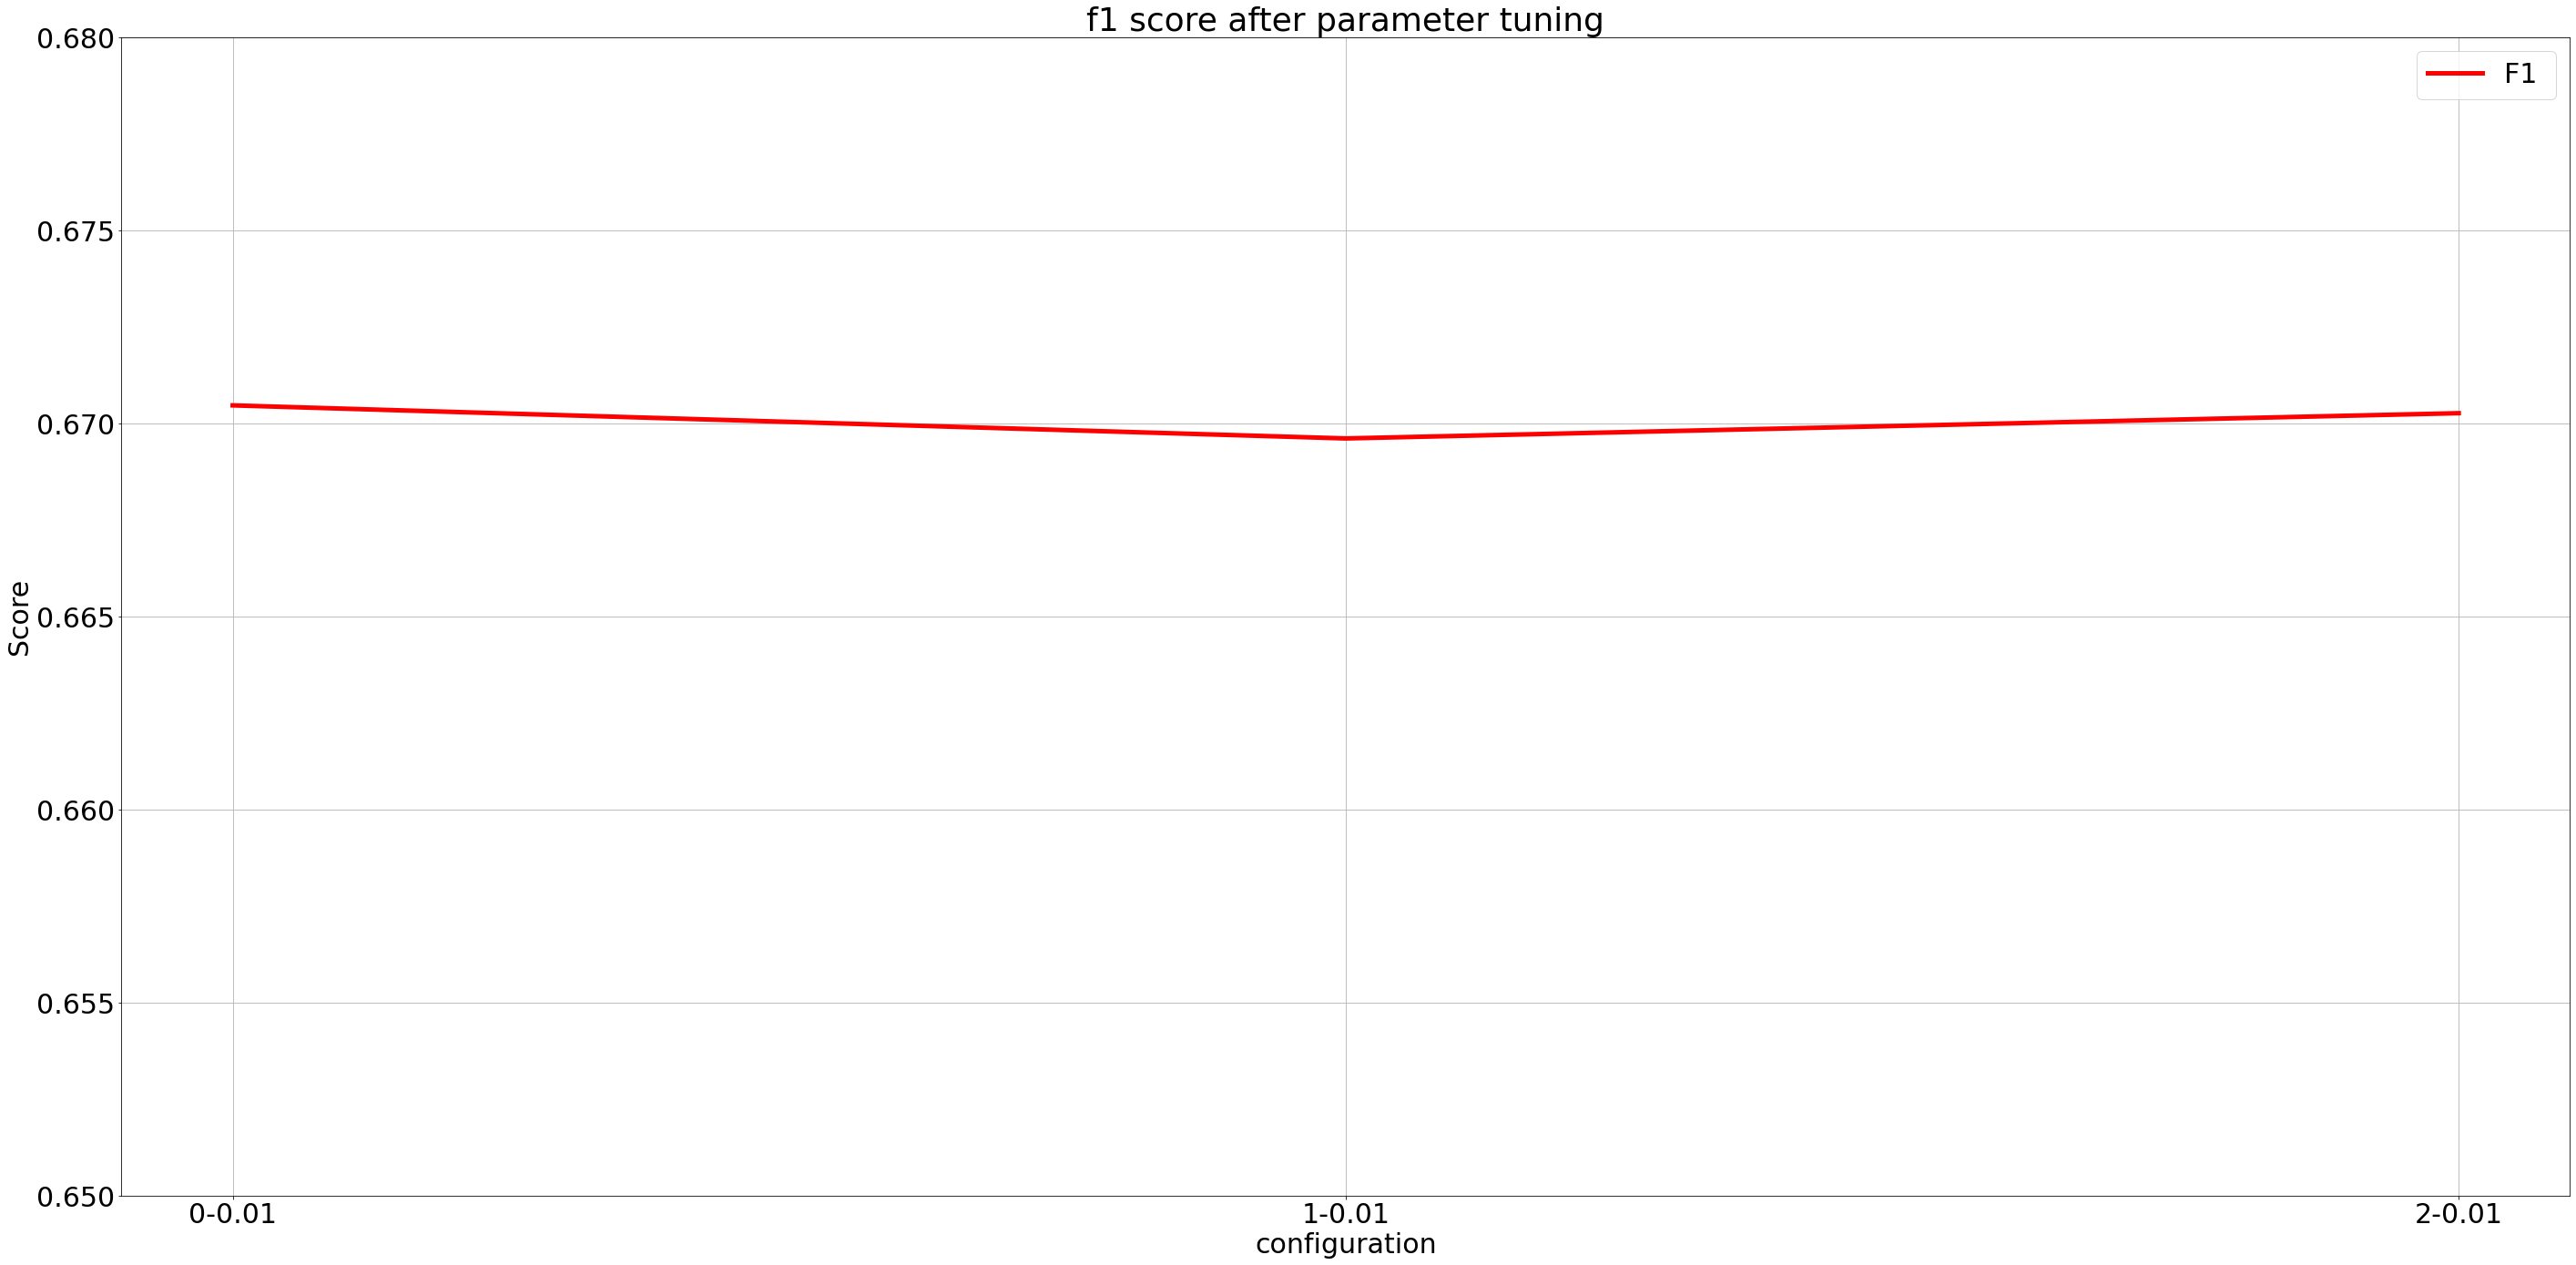

In [26]:
plt.figure(figsize=(40,20))
plt.rc('font', size=30)
plt.title('f1 score after parameter tuning')
plt.xlabel("configuration")
plt.ylabel("Score")
ax = plt.axes()
ax.set_ylim(0.65, 0.68)
pad = 0.005

labels = [f"{i}-{p}" for i,p in enumerate(best_param)]
colors = {'1': 'r', '2':'b', '3':'c', '4':'y'}
scorer = 'F1'


# Y_axis = np.array([best_score_1, best_score_2, best_score_3, best_score_4])
# 
X_axis = np.array(labels)

ax.plot(X_axis, Y_axis_f1, '-', color=colors['1'],label="%s " % ("F1"), linewidth=5)
# ax.plot(X_axis, Y_axis_recall, '-', color=colors['2'],label="%s " % ("Recall"), linewidth=5)
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("LOF_graph_v2_fw.png", dpi=100)

plt.show()

# Comparison against default values

In [26]:
f1_tuned = []
auc_tuned = []
r_tuned = []
f1_not_tuned = []

In [28]:
rs = 1
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)

c = best_param[0]
nnb = 100

stime = time.time()
y_pred = LocalOutlierFactor(n_neighbors= nnb, metric='euclidean', algorithm = 'auto', contamination=c, n_jobs=-1).fit_predict(x_test)
print("Time for IF fitting: %.3f" % (time.time() - stime))
f = f1_score(y_test, y_pred)
print(f"---{f}")
f1_tuned.append(f)
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_tuned.append(a)
r = recall_score(y_test, y_pred)
print(f"---{r}")
r_tuned.append(r)
y_pred = LocalOutlierFactor(n_jobs = -1).fit_predict(x_test)
f = f1_score(y_test, y_pred)
print(f"---{f}")
f1_not_tuned.append(f)

Time for IF fitting: 0.407
---0.9829448385695672
---0.5628172992993465
---0.9709954233409611
---0.9782899714801234


In [30]:
rs = 2
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)

c = best_param[1]
nnb = 200

stime = time.time()
y_pred = LocalOutlierFactor(n_neighbors= nnb, metric='euclidean', algorithm = 'auto', contamination=c, n_jobs=-1).fit_predict(x_test)
print("Time for IF fitting: %.3f" % (time.time() - stime))
f = f1_score(y_test, y_pred)
print(f"---{f}")
f1_tuned.append(f)
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_tuned.append(a)
r = recall_score(y_test, y_pred)
print(f"---{r}")
r_tuned.append(r)
y_pred = LocalOutlierFactor(n_jobs = -1).fit_predict(x_test)
f = f1_score(y_test, y_pred)
print(f"---{f}")
f1_not_tuned.append(f)

Time for IF fitting: 0.644
---0.9828379590773594
---0.5086483015185218
---0.9707849751300669
---0.9754134219966751


In [31]:
rs = 3
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)

c = best_param[2]
nnb = 500

stime = time.time()
y_pred = LocalOutlierFactor(n_neighbors= nnb, metric='euclidean', algorithm = 'auto', contamination=c, n_jobs=-1).fit_predict(x_test)
print("Time for IF fitting: %.3f" % (time.time() - stime))
f = f1_score(y_test, y_pred)
print(f"---{f}")
f1_tuned.append(f)
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_tuned.append(a)
r = recall_score(y_test, y_pred)
print(f"---{r}")
r_tuned.append(r)
y_pred = LocalOutlierFactor(n_jobs = -1).fit_predict(x_test)
f = f1_score(y_test, y_pred)
print(f"---{f}")
f1_not_tuned.append(f)

Time for IF fitting: 1.795
---0.9567180584024002
---0.5614602984050763
---0.9205396444292002
---0.9767292663011782


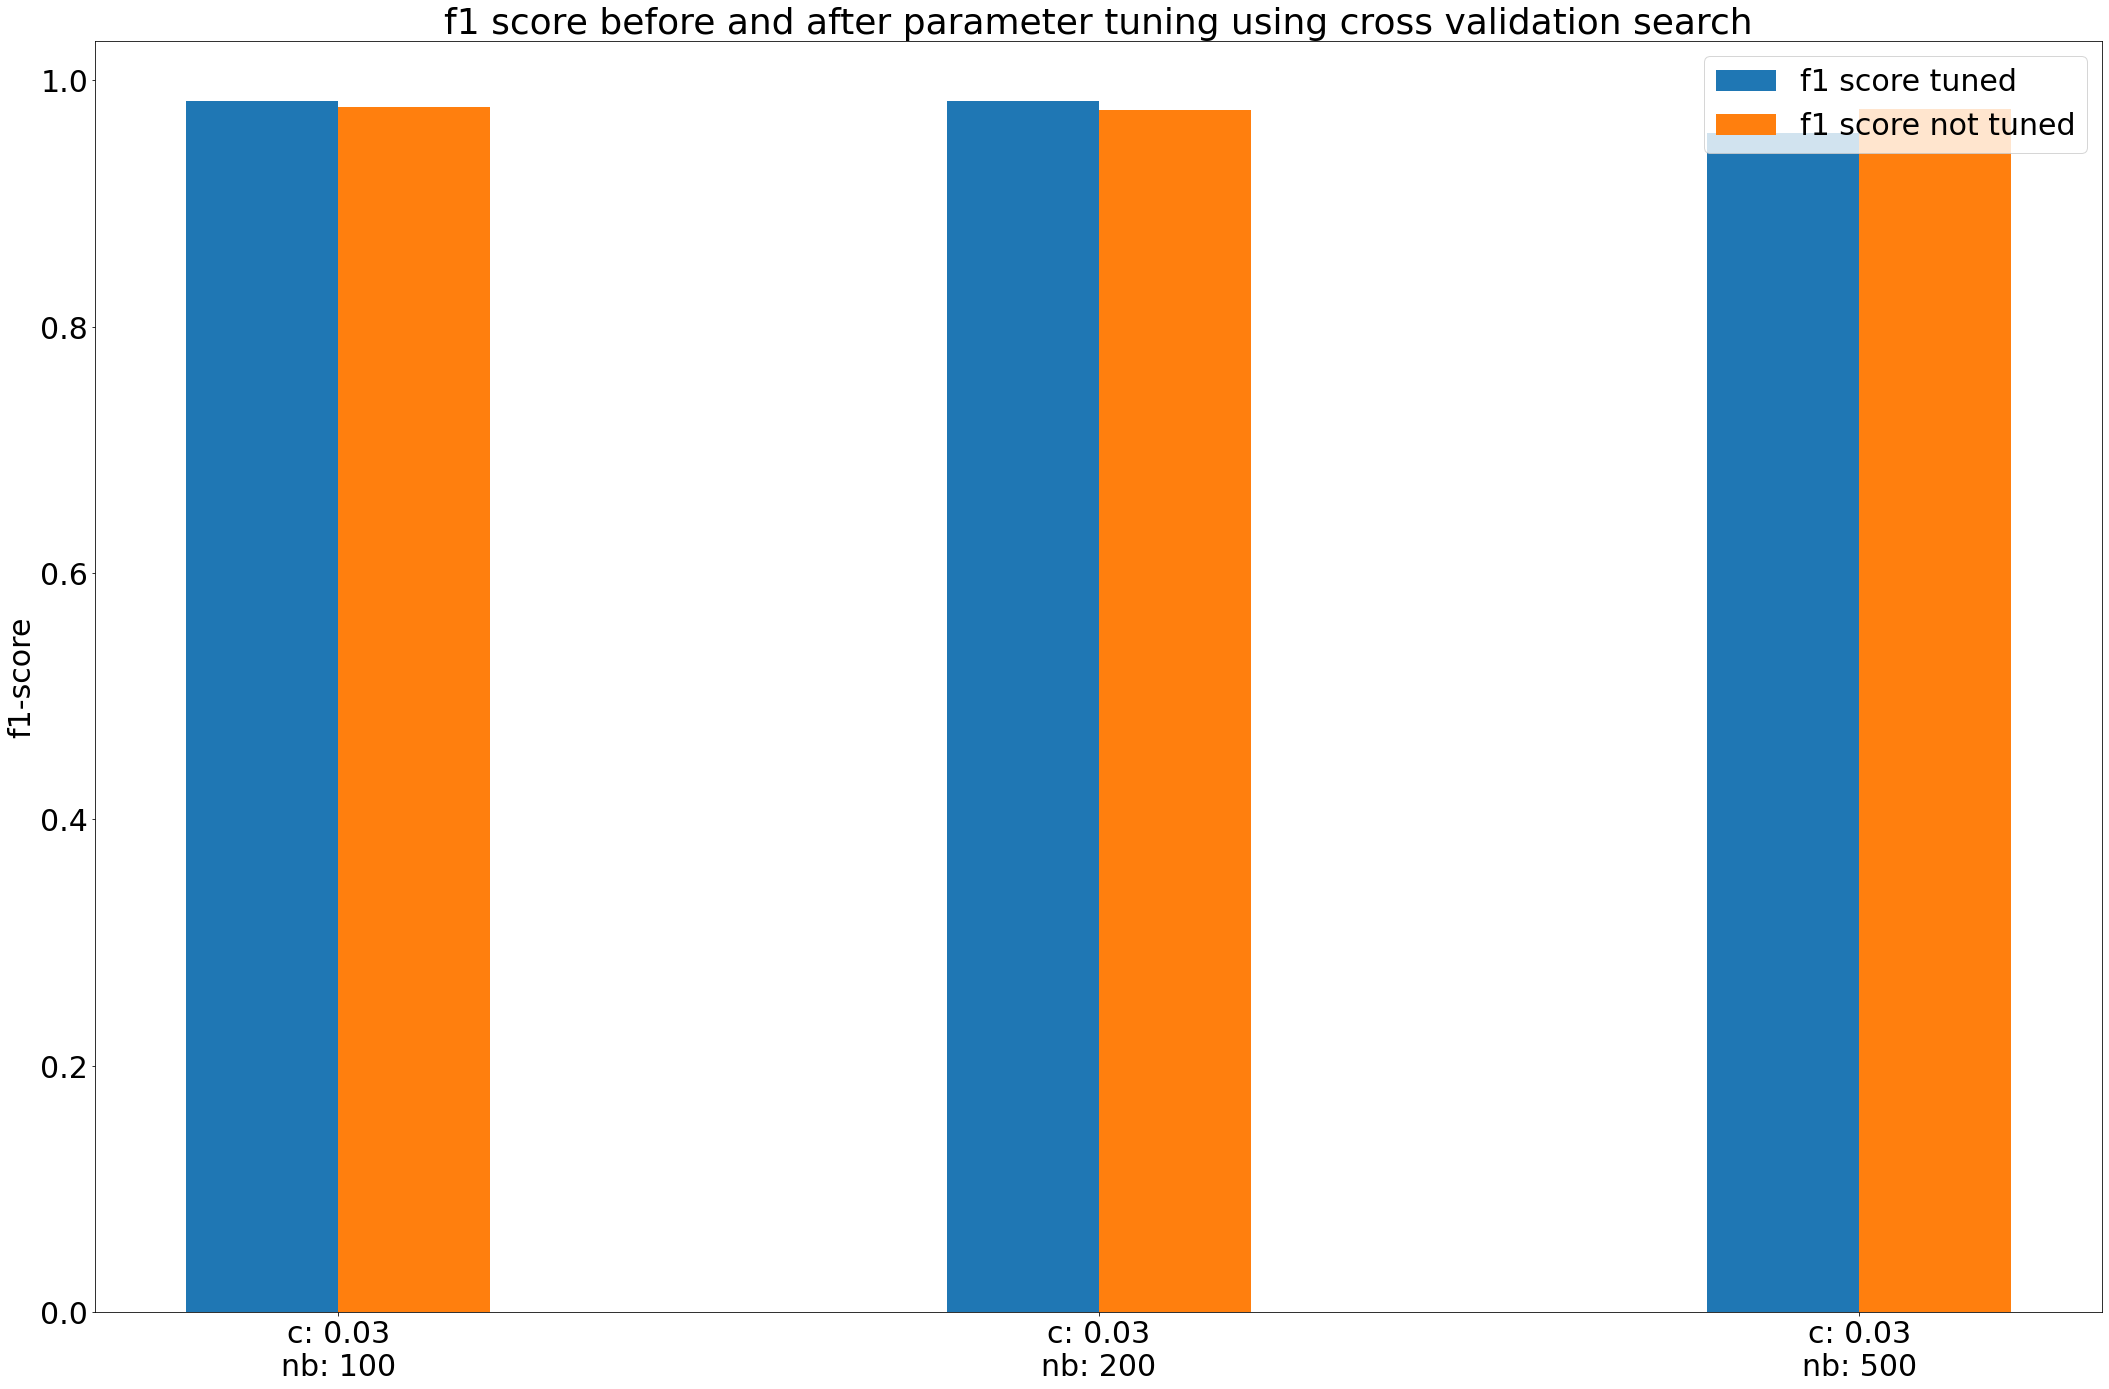

In [25]:
fig, ax = plt.subplots(figsize = (30,20))
plt.rc('font', size=30)

width = 1
labels = [f"c: {best_param[0]}\nnb: {100}", 
          f"c: {best_param[0]}\nnb: {200}", 
          f"c: {best_param[0]}\nnb: {500}"]
ax.set_xticks([i*5 + width/2 for i in range(len(f1_tuned))])
ax.set_xticklabels(labels)
ax.set_ylabel('f1-score')

ax.set_title('f1 score before and after parameter tuning using cross validation search')

ax.bar([i*5 for i in range(len(f1_tuned))], f1_tuned, width=width)
ax.bar([i*5 + width for i in range(len(f1_not_tuned))], f1_not_tuned, width=width)
fig.tight_layout()
ax.legend(['f1 score tuned', 'f1 score not tuned'])
plt.show()

In [33]:
import statistics 
m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")

0.5443086330743149 \pm 0.03089020553279924
0.9776567307392506 \pm 0.011705195665422871
0.9541066809667428 \pm 0.029070096810071052


# Time analysis

In [2]:
from imports import *

from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
import time

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]

dfsf = df[df["logged_in"]== 1]
print(len(dfsf)- len(dfsf.loc[dfsf["target"]=='normal.']))
dfsf = dfsf[sf_columns + ["target"]] 
# print(dfsf.head(1))
# Split the dataset into 2 classes for consistent anomaly_rate when sampling
dfsf_normal = dfsf.loc[dfsf["target"]=='normal.']
dfsf_attack = dfsf.loc[dfsf["target"]!='normal.']
# print(f"A sample normal frame: \t {dfsf_normal.head(1)}")
# print("-----------------")
# print(f"A sample attack frame: \t {dfsf_attack.head(1)}")

3377


In [3]:
r = 0.01
dfsa = df[sa_columns + ["target"]] 
dfsa_normal = dfsa.loc[dfsa["target"]=='normal.']
n_records = int(np.ceil(len(dfsa_normal)*r/(1-r)))
dfsa_attack = df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1)

anomaly rate is 0.5% out of 70307 records
anomaly rate is 1.0% out of 98261 records
anomaly rate is 0.5% out of 140613 records
anomaly rate is 1.0% out of 196521 records
anomaly rate is 0.5% out of 210920 records
anomaly rate is 1.0% out of 294782 records
anomaly rate is 0.5% out of 281227 records
anomaly rate is 1.0% out of 393043 records


<ipython-input-4-d601b63fd200>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


ValueError: x and y must have same first dimension, but have shapes (10,) and (4,)

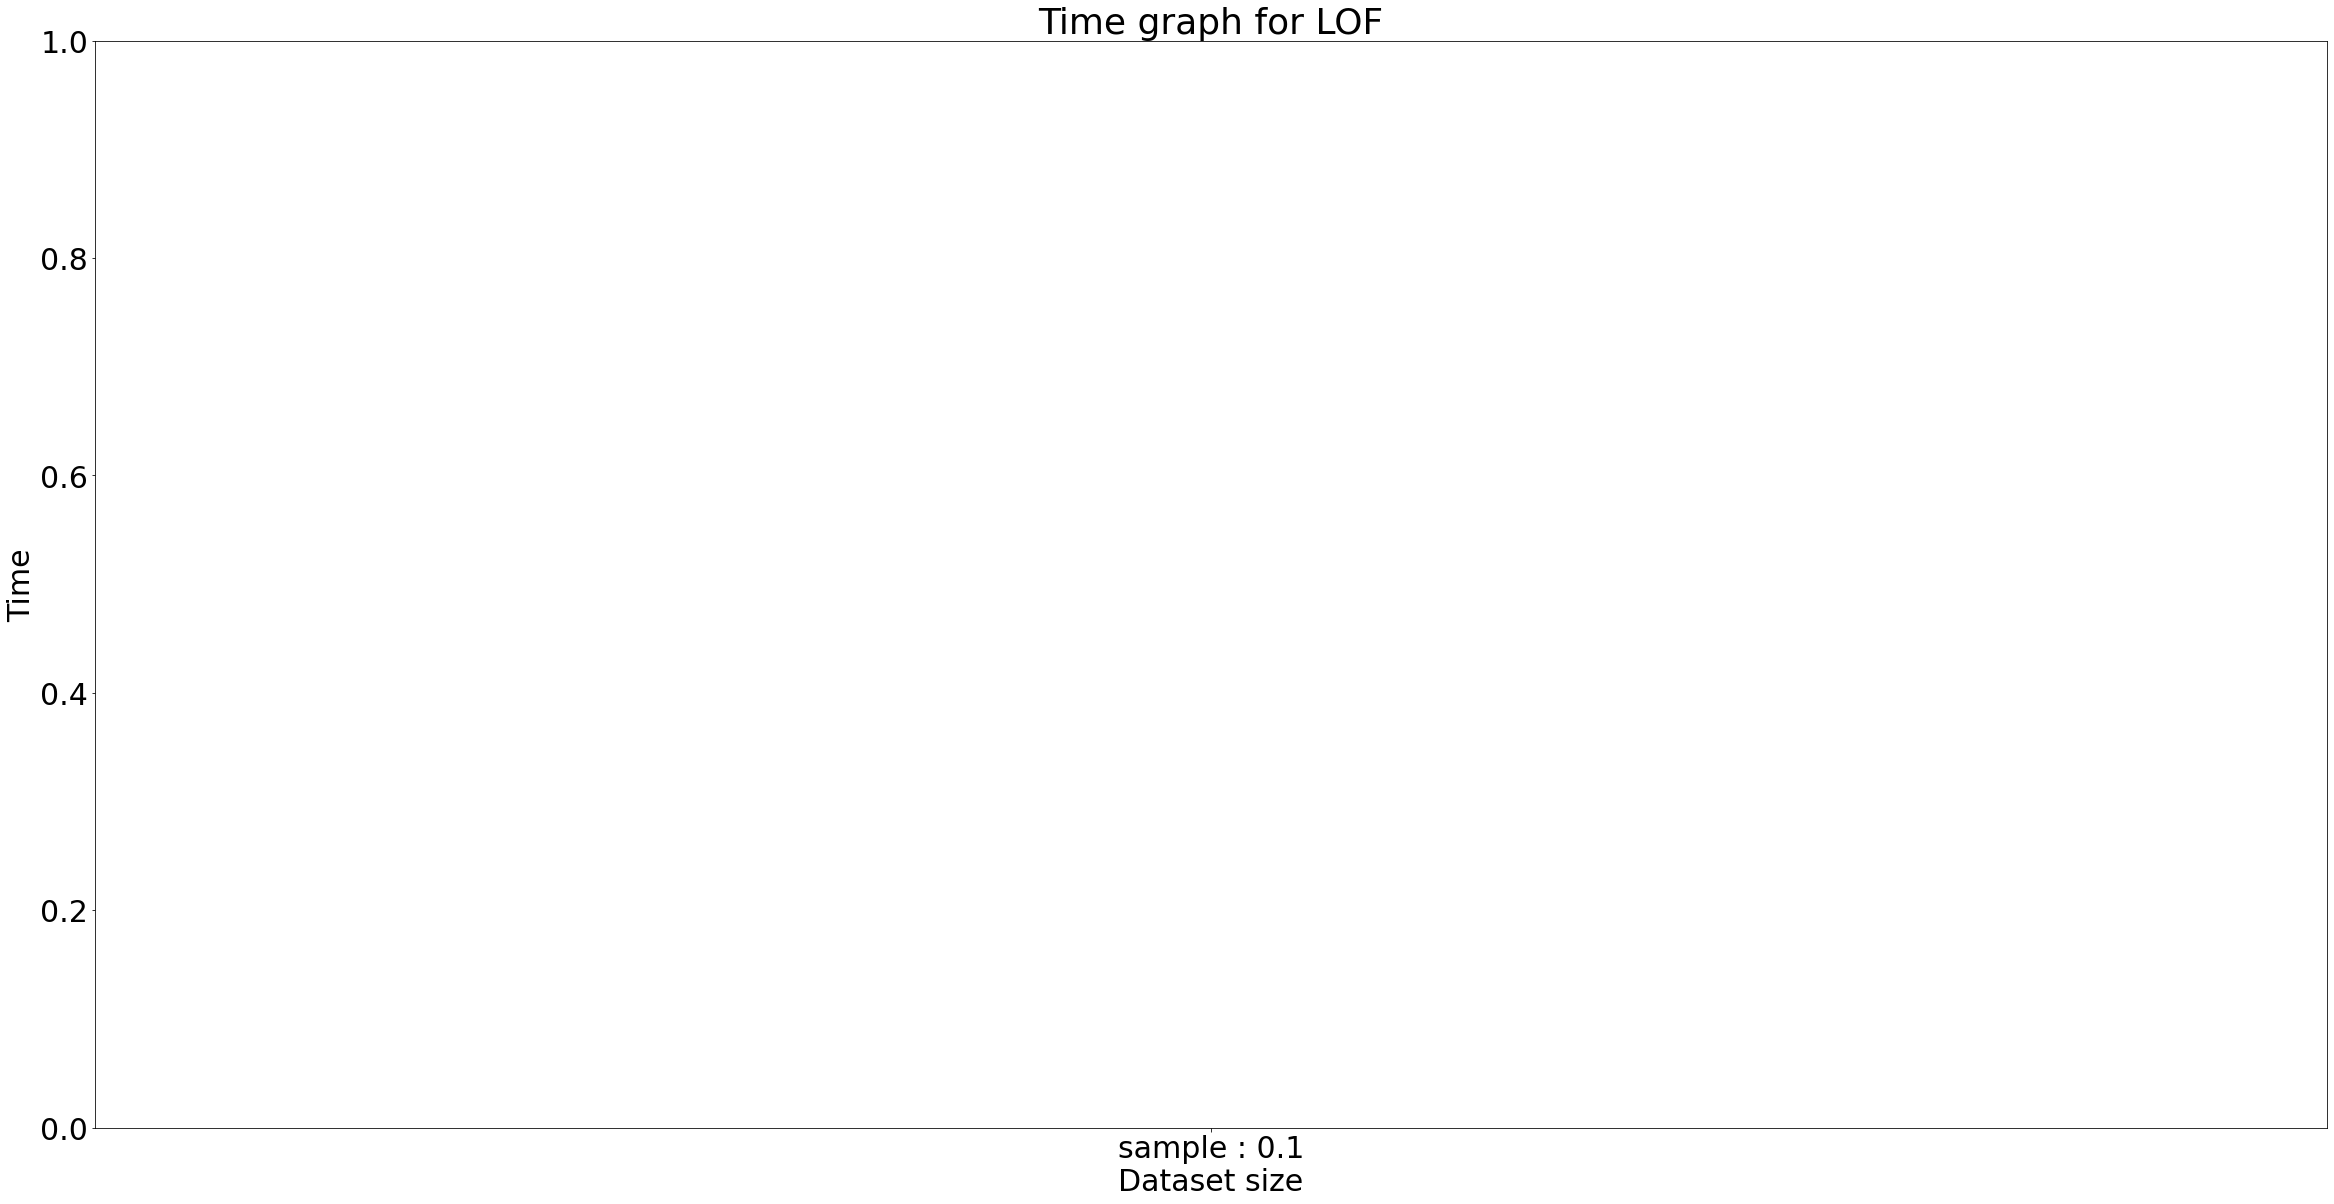

In [4]:
tysf = []
tysa = []
for i in range(1, 5):
    frac = 0.1 * i
    rs = i

    ### SF ###
    dfSF = dfsf_normal.sample(frac = frac, random_state = 1).append(dfsf_attack.sample(frac = frac, random_state = 1))
    anomaly_rate = 1.0 - len(dfSF.loc[dfSF["target"]=='normal.'])/len(dfSF)
    print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfSF)} records")
    dfSF['binary_target'] = [1 if x=='normal.' else -1 for x in dfSF["target"]]
    toDecode = toDecodeSF
    leSF = preprocessing.LabelEncoder()
    for f in toDecode:
        dfSF[f] = leSF.fit_transform(dfSF[f])
    ##########
    
    x_train, x_test, y_train, y_test = train_test_split(dfSF.drop(["target", "binary_target"], axis=1), dfSF['binary_target'], test_size=0.25, random_state=rs)
    s = datetime.datetime.now()
    y_pred = LocalOutlierFactor(n_neighbors= 100, metric='euclidean', algorithm = 'auto', contamination=0.01, n_jobs=-1).fit_predict(x_train)
    t = datetime.datetime.now() - s
    tysf.append(t)
    
    ### SA ###
    dfsa_frac = dfsa_normal.sample(frac = frac, random_state = 1).append(dfsa_attack.sample(frac = frac, random_state = 1))
    anomaly_rate = 1.0 - len(dfsa_frac.loc[dfsa_frac["target"]=='normal.'])/len(dfsa_frac)
    print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsa_frac)} records")
    dfsa_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsa_frac["target"]]
    toDecode = toDecodeSA
    leSF = preprocessing.LabelEncoder()
    for f in toDecode:
        dfsa_frac[f] = leSF.fit_transform(dfsa_frac[f])
    ##########
    
    x_train, x_test, y_train, y_test = train_test_split(dfsa_frac.drop(["target", "binary_target"], axis=1), dfsa_frac['binary_target'], test_size=0.25, random_state=rs)
    s = datetime.datetime.now()
    y_pred = LocalOutlierFactor(n_neighbors= 100, metric='euclidean', algorithm = 'auto', contamination=0.01, n_jobs=-1).fit_predict(x_train)
    t = datetime.datetime.now() - s
    tysa.append(t)


In [5]:
tysa

[datetime.timedelta(seconds=10, microseconds=978597),
 datetime.timedelta(seconds=43, microseconds=431211),
 datetime.timedelta(seconds=82, microseconds=59649),
 datetime.timedelta(seconds=135, microseconds=325272)]

In [12]:
tysf

[datetime.timedelta(seconds=2, microseconds=762351),
 datetime.timedelta(seconds=7, microseconds=12969),
 datetime.timedelta(seconds=15, microseconds=89171),
 datetime.timedelta(seconds=19, microseconds=191818)]

In [14]:
tysf[0].total_seconds()

2.762351

<ipython-input-16-b5c134b9d352>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


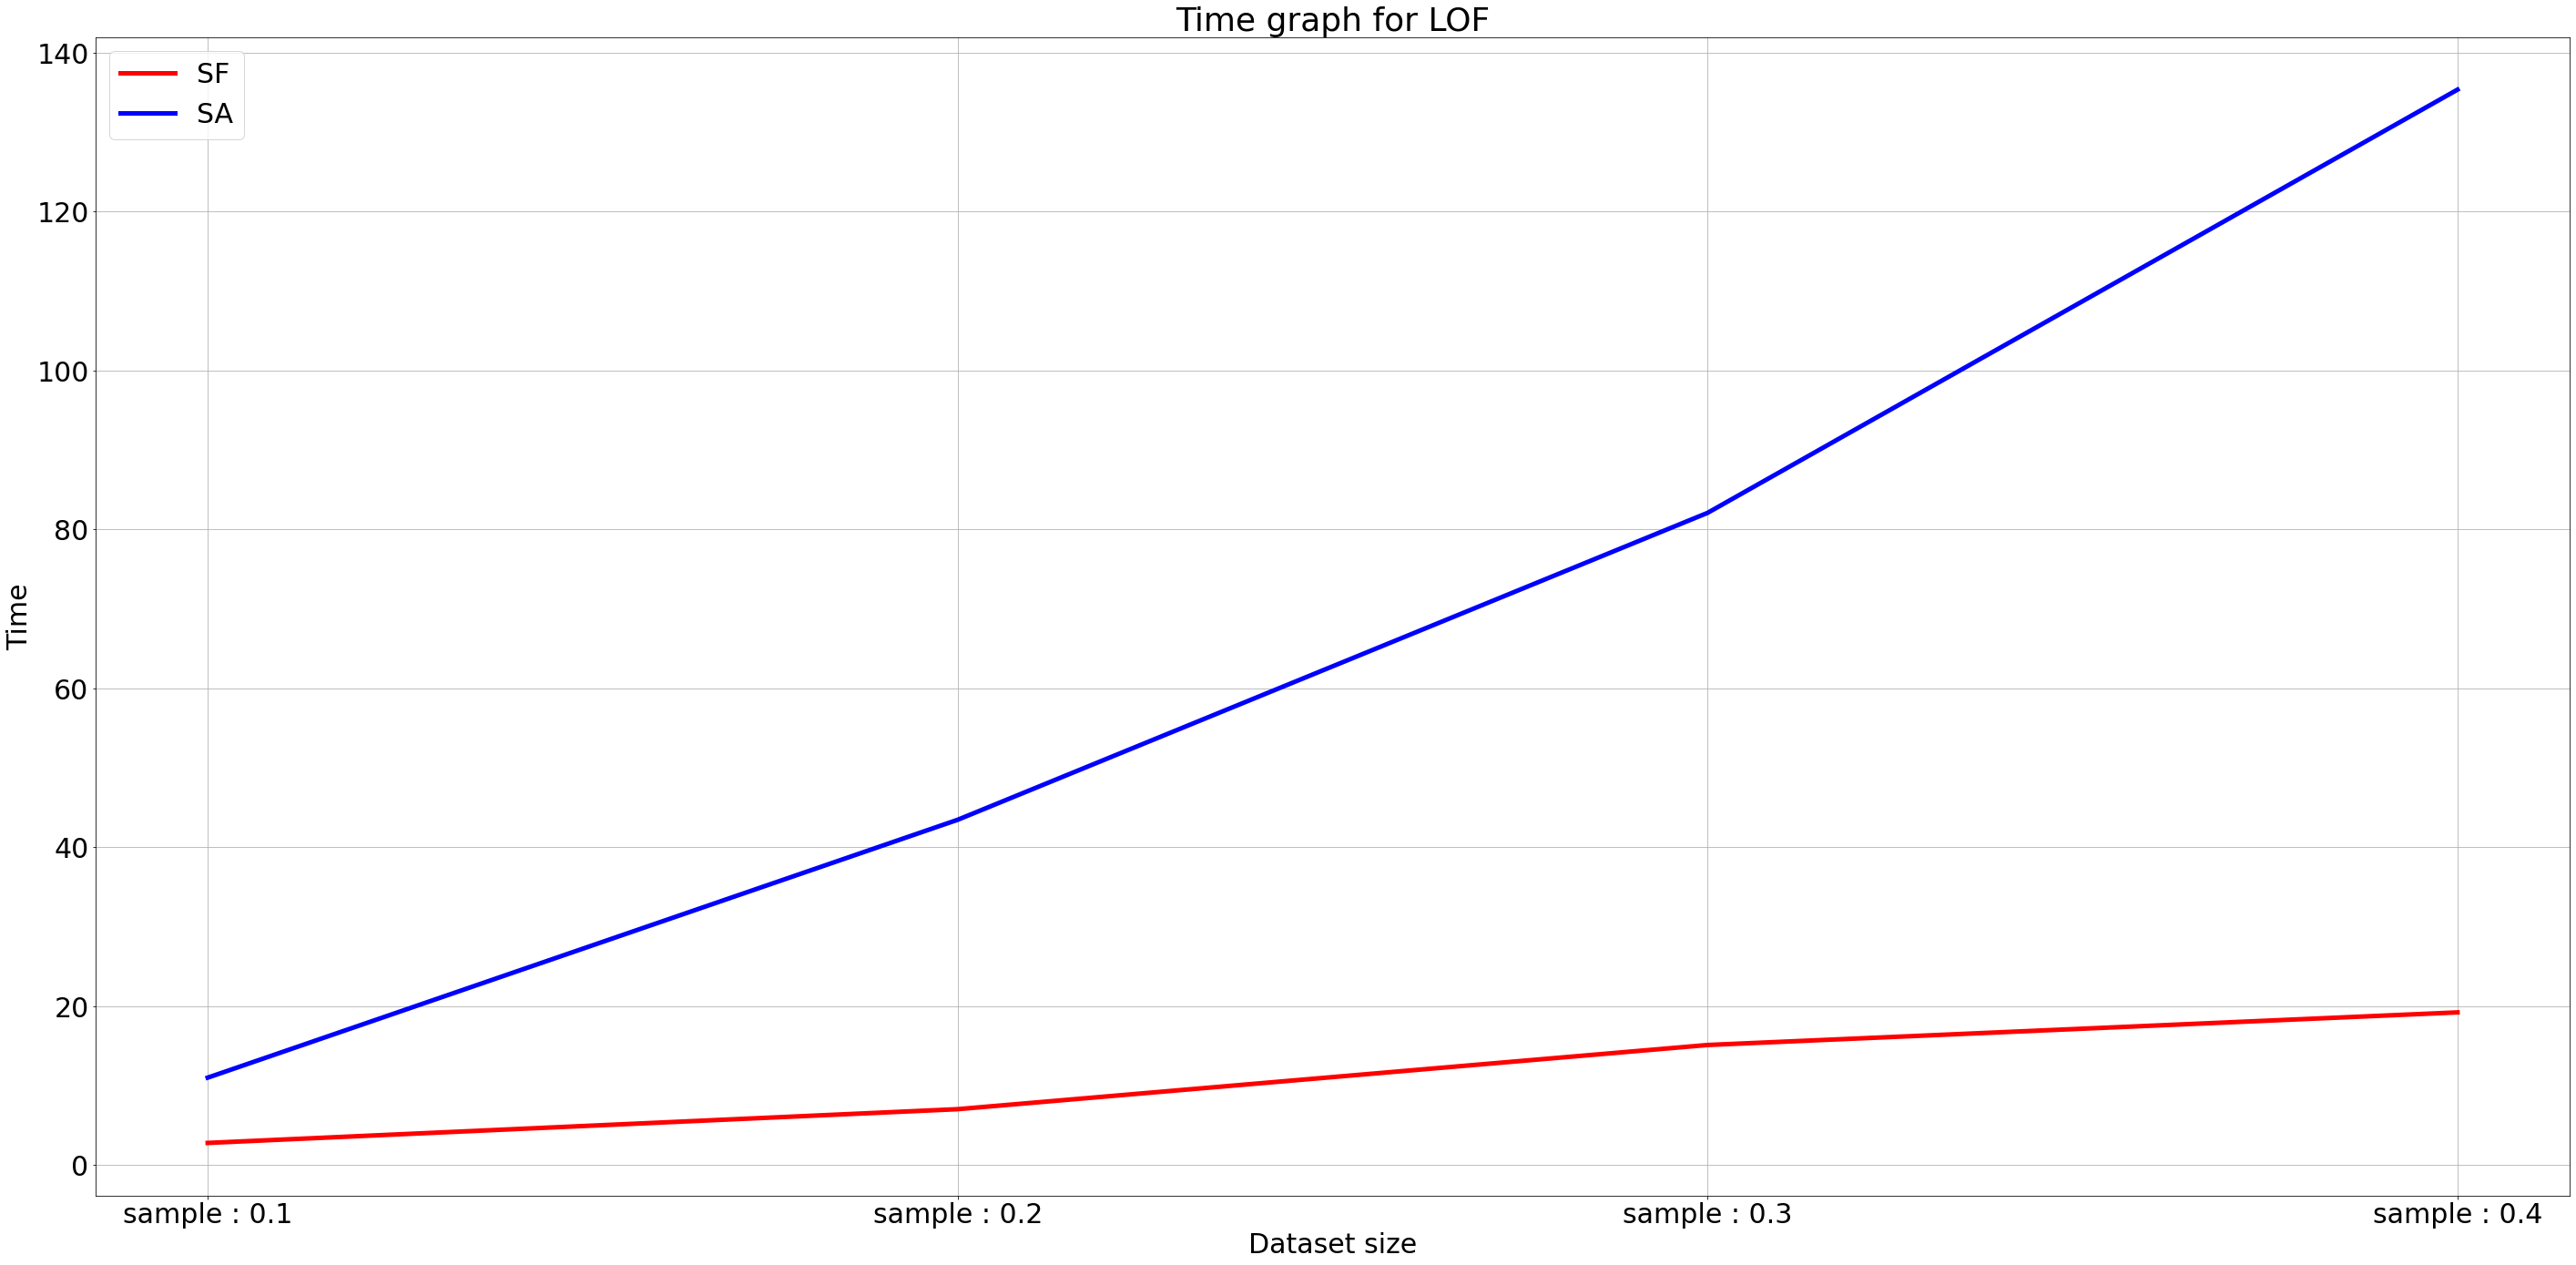

In [16]:
plt.figure(figsize=(40,20))
plt.rc('font', size=30)
plt.title('Time graph for LOF')
plt.xlabel("Dataset size")
plt.ylabel("Time")
ax = plt.axes()
pad = 0.005

labels = [f"sample : {0.1*i:.2}" for i in range(1, 5)]
colors = {'1': 'r', '2':'b', '3':'c', '4':'y'}

Y_axis_sf = [a.total_seconds() for a in tysf]
Y_axis_sa = [a.total_seconds() for a in tysa]

# Y_axis = np.array([best_score_1, best_score_2, best_score_3, best_score_4])
# 
X_axis = np.array(labels)

ax.plot(X_axis, Y_axis_sf, '-', color=colors['1'],label="SF", linewidth=5)
ax.plot(X_axis, Y_axis_sa, '-', color=colors['2'],label="SA", linewidth=5)
plt.legend(['SF', 'SA'])
plt.grid('off')
plt.tight_layout()
plt.savefig("LOF_graph_time.png", dpi=100)

plt.show()